<a href="https://colab.research.google.com/github/YosefOwenManullang/Make-a-Machine-Learning-Model-with-Data-Time-Series/blob/main/Make_a_Machine_Learning_Model_with_Data_Time_Series_Owen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout
import matplotlib.pyplot as plt

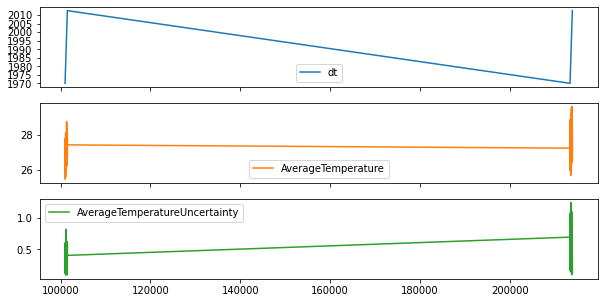

In [5]:
df = pd.read_csv('/content/drive/MyDrive/GlobalLandTemperaturesByMajorCity.csv', encoding= 'unicode_escape')
df.drop(['City','Latitude','Longitude'], axis=1, inplace=True)

df['dt'] = pd.to_datetime(df['dt'])  
get_data = (df['dt'] > '1970-01-01') & (df['dt'] <= '2012-09-01') #data yang diambil tahun 1970 - 2012
df = df.loc[get_data]

df = df.loc[df['Country'].isin(['Indonesia'])]  #mengambil data negara Indonesia
df.drop(['Country'], axis=1, inplace=True)
df.reset_index(drop=True)
df.dropna(subset=['AverageTemperature'],inplace=True) #menghilankan baris yang tidak mempunyai nilai
df.dropna(subset=['AverageTemperatureUncertainty'],inplace=True)
df_plot = df
df_plot[df_plot.columns.to_list()].plot(subplots=True, figsize=(10, 5))
plt.show()

### Plot Data

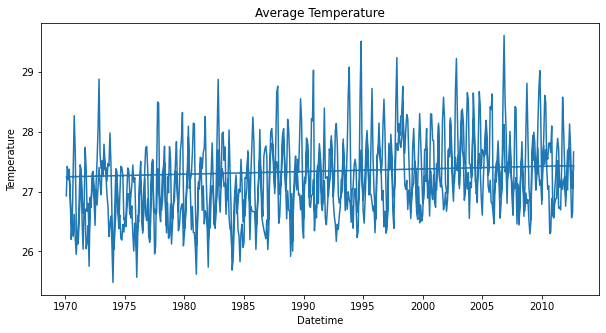

In [6]:
dates = df['dt'].values
temp = df['AverageTemperature'].values

dates = np.array(dates)
temp = np.array(temp)

plt.figure(figsize=(10,5))
plt.plot(dates, temp)

plt.title('Average Temperature')
plt.ylabel('Temperature')
plt.xlabel('Datetime')

df.dtypes
x_train, x_valid, y_train, y_valid = train_test_split(temp, dates, train_size=0.8, test_size = 0.2, shuffle = False )

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

### Model sequential

In [9]:
tf.keras.backend.set_floatx('float64')
train_set = windowed_dataset(x_train, window_size=64, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=64, batch_size=200, shuffle_buffer=1000)
model = Sequential([
    Bidirectional(LSTM(60, return_sequences=True)),
    Bidirectional(LSTM(60)),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])

Fungsi Callback

In [10]:
Mae = (df['AverageTemperature'].max() - df['AverageTemperature'].min()) * 10/100
print(Mae)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<2.4 and logs.get('val_mae')<2.4):
      print("\nMAE < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

0.4125999999999994


In [12]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, validation_data = val_set, 
          callbacks=[callbacks])

Epoch 1/100
4/4 [==============================] - 31s 2s/step - loss: 2.8978 - mae: 3.3863 - val_loss: 8.4427 - val_mae: 8.9427
Epoch 2/100
4/4 [==============================] - 6s 2s/step - loss: 5.1494 - mae: 5.5975 - val_loss: 3.8117 - val_mae: 4.3117
Epoch 3/100
4/4 [==============================] - 4s 1s/step - loss: 4.4532 - mae: 4.9532 - val_loss: 2.9968 - val_mae: 3.4968
Epoch 4/100
4/4 [==============================] - 6s 2s/step - loss: 2.9412 - mae: 3.4412 - val_loss: 1.4876 - val_mae: 1.9811
Epoch 5/100
4/4 [==============================] - 5s 1s/step - loss: 2.2123 - mae: 2.6839 - val_loss: 1.1711 - val_mae: 1.6544
Epoch 6/100
4/4 [==============================] - 6s 2s/step - loss: 2.4453 - mae: 2.9333 - val_loss: 0.2113 - val_mae: 0.5199
Epoch 7/100
4/4 [==============================] - ETA: 0s - loss: 1.3545 - mae: 1.7553
MAE < 10% skala data
4/4 [==============================] - 5s 1s/step - loss: 1.3545 - mae: 1.7553 - val_loss: 0.2457 - val_mae: 0.5536


### Loss Model

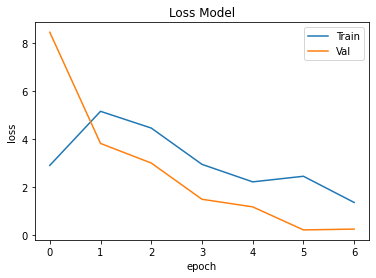

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Akurasi Model

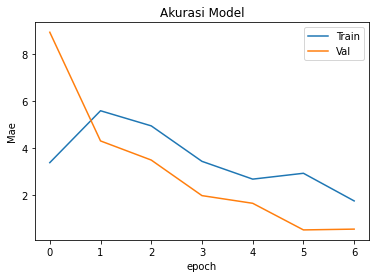

In [14]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()